In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from google.colab import files

In [ ]:
uploaded = files.upload()

Saving data-2021.csv to data-2021.csv
Saving data.csv to data.csv
Saving log-2021.csv to log-2021.csv
Saving log.csv to log.csv


In [27]:
# get the paths of original datasets
data_path = '/content/data.csv'
log_path = '/content/log.csv'
data_path_2021 = '/content/data-2021.csv'
log_path_2021 = '/content/log-2021.csv'

# load data
data_df = pd.read_csv(data_path)
log_df = pd.read_csv(log_path)
data_df_2021 = pd.read_csv(data_path_2021)
log_df_2021 = pd.read_csv(log_path_2021)

# rename the student in 2021
data_df_2021['Student'] = data_df_2021['Student'] + '-2021'
log_df_2021['Student'] = log_df_2021['Student'] + '-2021'

# merge data
data_df = pd.concat([data_df, data_df_2021])
log_df = pd.concat([log_df, log_df_2021])

columns_with_missing_values = ['Week 3 quiz', 'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz',
       'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz', 'Week 10 quiz',
       'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
       'Week 15 quiz', 'Week 16 quiz', 'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
       'Week 7 homework', 'Week 8 homework', 'Week 9 homework',
       'Week 10 homework', 'Week 11 homework', 'Week 13 homework',
       'Week 14 homework', 'Week 15 homework']
columns_not_missing_values = ['Week 1 quiz', 'Week 2 quiz',
       'Week 3 quiz', 'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz',
       'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz', 'Week 10 quiz',
       'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
       'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework', 'Week 2 homework',
       'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
       'Week 7 homework', 'Week 8 homework', 'Week 9 homework',
       'Week 10 homework', 'Week 11 homework', 'Week 13 homework',
       'Week 14 homework', 'Week 15 homework']

columns_name_student = "Student"
columns_name_score = "Score"
columns_name_grade = "Grade"

columns_name_activity = "Activity"
columns_name_day = "Day"
columns_name_time = "Time"
add_column_activity_weeknumber = "Activity_Num"
add_column_activity_score = "Activity Score"

In [29]:
# in data_df, subsititute - with NaN in column score
data_df[columns_name_score] = data_df[columns_name_score].replace('-', np.nan)
data_df[columns_name_score] = pd.to_numeric(data_df[columns_name_score], errors='coerce')

# in data_df, delete the data that does not participate in any activity or got F due to other activtiy
# in data_df, delete the data that got A due to pre-exam
data_df = data_df.dropna(subset=[columns_name_score])
data_df = data_df.drop(data_df[(data_df[columns_name_score] > 50) & (data_df[columns_name_grade] == 'F')].index)

conditions = (data_df[columns_with_missing_values].eq(0).all(axis=1)) & (data_df[columns_name_grade] == 'A')
data_df = data_df[~conditions]

# in log_df, delete the data after ddl
log_df[columns_name_time] = pd.to_datetime(log_df[columns_name_time])
log_df[add_column_activity_weeknumber] = log_df[columns_name_activity].str.extract(r"(\d+)")
log_df[add_column_activity_weeknumber] = log_df[add_column_activity_weeknumber].fillna(0)
log_df[add_column_activity_weeknumber] = log_df[add_column_activity_weeknumber].astype(int)

week1 = (log_df[add_column_activity_weeknumber] == 1)
week2_16 = (log_df[add_column_activity_weeknumber] > 1) & (log_df[add_column_activity_weeknumber] <= 16)

time_start_for_week2_16 = (log_df[columns_name_time].dt.time < pd.to_datetime('18:00:00').time())
time_end_for_week2_16 = (log_df[columns_name_time].dt.time > pd.to_datetime('8:00:00').time())

invalid_for_week1 = (log_df[columns_name_day] < 1) | (log_df[columns_name_day] > 7)

invalid_start_for_week2_16 = (log_df[columns_name_day] < (7 * (log_df[add_column_activity_weeknumber] -1) - 3)) | ((log_df[columns_name_day] == (7 * (log_df[add_column_activity_weeknumber] -1) - 3)) & time_start_for_week2_16)
invalid_end_for_week2_16 = (log_df[columns_name_day] > (7 * (log_df[add_column_activity_weeknumber] -1) + 4)) | ((log_df[columns_name_day] == (7 * (log_df[add_column_activity_weeknumber] -1) + 4)) & time_end_for_week2_16)

condition1 = week1 & invalid_for_week1
condition2 = week2_16 & (invalid_start_for_week2_16 | invalid_end_for_week2_16)

log_df.reset_index(drop=True, inplace=True)
log_df = log_df.drop(log_df[condition1].index)
if not log_df.empty:
    log_df = log_df.drop(log_df[condition2].index)
log_df.reset_index(drop=True, inplace=True)

log_df = log_df.drop(add_column_activity_weeknumber, axis=1)

<ipython-input-29-68ddc4a75517>:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  log_df = log_df.drop(log_df[condition2].index)


In [30]:
# in log_df, build new column Score_First and Score_Last for first score and last score respectively
suffixes_first = '_First'
suffixes_last = '_Last'
columns_name_first_score = columns_name_score + suffixes_first
columns_name_last_score = columns_name_score + suffixes_last
columns_name_first_day = columns_name_day + suffixes_first
columns_name_last_day = columns_name_day + suffixes_last
columns_name_first_time = columns_name_time + suffixes_first
columns_name_last_time = columns_name_time + suffixes_last

log_df[columns_name_day] = log_df[columns_name_day].astype(int)
log_df_sorted = log_df.sort_values([columns_name_student, columns_name_activity, columns_name_day, columns_name_time])

first_scores = log_df_sorted.groupby([columns_name_student, columns_name_activity]).first()
last_scores = log_df_sorted.groupby([columns_name_student, columns_name_activity]).last()

log_df = pd.merge(log_df, first_scores, on=[columns_name_student, columns_name_activity], suffixes=('', suffixes_first))
log_df = pd.merge(log_df, last_scores, on=[columns_name_student, columns_name_activity], suffixes=('', suffixes_last))

log_df = log_df.drop(columns_name_day, axis=1)
log_df = log_df.drop(columns_name_time, axis=1)
log_df = log_df.drop(columns_name_first_day, axis=1)
log_df = log_df.drop(columns_name_last_day, axis=1)
log_df = log_df.drop(columns_name_first_time, axis=1)
log_df = log_df.drop(columns_name_last_time, axis=1)

In [31]:
# in log_df, detele all the data without maximum score
max_score_df = log_df.groupby([columns_name_student, columns_name_activity, columns_name_first_score, columns_name_last_score])[columns_name_score].max().reset_index()
log_df = log_df.merge(max_score_df, on=[columns_name_student, columns_name_activity, columns_name_first_score, columns_name_last_score, columns_name_score], how='inner')
log_df.drop_duplicates(subset=[columns_name_student, columns_name_activity, columns_name_first_score, columns_name_last_score], keep='first', inplace=True)

In [32]:
# merge data and log based on student and activity
# Pivot log_df to get the columns for max score, first score, and last score
max_score_df = log_df.pivot(index='Student', columns='Activity', values='Score').add_suffix('_maxscore')
first_score_df = log_df.pivot(index='Student', columns='Activity', values='Score_First').add_suffix('_firstscore')
last_score_df = log_df.pivot(index='Student', columns='Activity', values='Score_Last').add_suffix('_lastscore')

# Merge the pivoted DataFrames with data_df
merged_df = data_df.merge(max_score_df, left_on='Student', right_index=True, how='left')
merged_df = merged_df.merge(first_score_df, left_on='Student', right_index=True, how='left')
merged_df = merged_df.merge(last_score_df, left_on='Student', right_index=True, how='left')

In [ ]:
data_df.to_csv('/content/data_df.csv', index=False)
files.download('/content/data_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
log_df.to_csv('/content/log_df.csv', index=False)
files.download('/content/log_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
merged_df.to_csv('/content/merged_df.csv', index=False)
files.download('/content/merged_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
from sklearn.model_selection import train_test_split

# define three sets of features
# first set: the number of attempts and maximum score of each exercise
features = ['Week 1 quiz', 'Week 2 quiz', 'Week 3 quiz',
            'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz', 'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz',
            'Week 10 quiz', 'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
            'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework', 'Week 2 homework',
            'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
            'Week 7 homework', 'Week 8 homework', 'Week 9 homework', 'Week 10 homework', 'Week 11 homework',
            'Week 13 homework', 'Week 14 homework', 'Week 15 homework', 'Week 1 homework_maxscore',
            'Week 1 quiz_maxscore', 'Week 10 homework_maxscore', 'Week 10 quiz_maxscore', 'Week 11 homework_maxscore',
            'Week 11 quiz_maxscore', 'Week 12 quiz_maxscore', 'Week 13 homework_maxscore', 'Week 13 quiz_maxscore',
            'Week 14 homework_maxscore', 'Week 14 quiz_maxscore', 'Week 15 homework_maxscore', 'Week 15 quiz_maxscore',
            'Week 16 quiz_maxscore', 'Week 2 homework_maxscore', 'Week 2 quiz_maxscore', 'Week 3 homework_maxscore',
            'Week 3 quiz_maxscore', 'Week 4 homework_maxscore', 'Week 4 quiz_maxscore', 'Week 5 homework_maxscore',
            'Week 5 quiz_maxscore', 'Week 6 quiz_maxscore', 'Week 7 homework_maxscore', 'Week 7 quiz_maxscore',
            'Week 8 homework_maxscore', 'Week 8 quiz_maxscore', 'Week 9 homework_maxscore', 'Week 9 quiz_maxscore']

# second set: maximum score of each exercise
features_new = ['Week 1 homework_maxscore',
            'Week 1 quiz_maxscore', 'Week 10 homework_maxscore', 'Week 10 quiz_maxscore', 'Week 11 homework_maxscore',
            'Week 11 quiz_maxscore', 'Week 12 quiz_maxscore', 'Week 13 homework_maxscore', 'Week 13 quiz_maxscore',
            'Week 14 homework_maxscore', 'Week 14 quiz_maxscore', 'Week 15 homework_maxscore', 'Week 15 quiz_maxscore',
            'Week 16 quiz_maxscore', 'Week 2 homework_maxscore', 'Week 2 quiz_maxscore', 'Week 3 homework_maxscore',
            'Week 3 quiz_maxscore', 'Week 4 homework_maxscore', 'Week 4 quiz_maxscore', 'Week 5 homework_maxscore',
            'Week 5 quiz_maxscore', 'Week 6 quiz_maxscore', 'Week 7 homework_maxscore', 'Week 7 quiz_maxscore',
            'Week 8 homework_maxscore', 'Week 8 quiz_maxscore', 'Week 9 homework_maxscore', 'Week 9 quiz_maxscore']

# third set: the number of attempts, first and last score of each exercise
features_third = ['Week 1 quiz', 'Week 2 quiz', 'Week 3 quiz',
            'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz', 'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz',
            'Week 10 quiz', 'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
            'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework', 'Week 2 homework',
            'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
            'Week 7 homework', 'Week 8 homework', 'Week 9 homework', 'Week 10 homework', 'Week 11 homework',
            'Week 13 homework', 'Week 14 homework', 'Week 15 homework', 'Week 1 homework_firstscore',
            'Week 1 quiz_firstscore', 'Week 10 homework_firstscore',
            'Week 10 quiz_firstscore', 'Week 11 homework_firstscore', 'Week 11 quiz_firstscore',
            'Week 12 quiz_firstscore', 'Week 13 homework_firstscore', 'Week 13 quiz_firstscore',
            'Week 14 homework_firstscore', 'Week 14 quiz_firstscore', 'Week 15 homework_firstscore',
            'Week 15 quiz_firstscore', 'Week 16 quiz_firstscore', 'Week 2 homework_firstscore',
            'Week 2 quiz_firstscore', 'Week 3 homework_firstscore', 'Week 3 quiz_firstscore',
            'Week 4 homework_firstscore', 'Week 4 quiz_firstscore', 'Week 5 homework_firstscore',
            'Week 5 quiz_firstscore', 'Week 6 quiz_firstscore', 'Week 7 homework_firstscore',
            'Week 7 quiz_firstscore', 'Week 8 homework_firstscore', 'Week 8 quiz_firstscore',
            'Week 9 homework_firstscore', 'Week 9 quiz_firstscore', 'Week 1 homework_lastscore',
            'Week 1 quiz_lastscore', 'Week 10 homework_lastscore', 'Week 10 quiz_lastscore',
            'Week 11 homework_lastscore', 'Week 11 quiz_lastscore', 'Week 12 quiz_lastscore',
            'Week 13 homework_lastscore', 'Week 13 quiz_lastscore', 'Week 14 homework_lastscore',
            'Week 14 quiz_lastscore', 'Week 15 homework_lastscore', 'Week 15 quiz_lastscore',
            'Week 16 quiz_lastscore', 'Week 2 homework_lastscore', 'Week 2 quiz_lastscore',
            'Week 3 homework_lastscore', 'Week 3 quiz_lastscore', 'Week 4 homework_lastscore',
            'Week 4 quiz_lastscore', 'Week 5 homework_lastscore', 'Week 5 quiz_lastscore',
            'Week 6 quiz_lastscore', 'Week 7 homework_lastscore', 'Week 7 quiz_lastscore',
            'Week 8 homework_lastscore', 'Week 8 quiz_lastscore', 'Week 9 homework_lastscore', 'Week 9 quiz_lastscore']

# define target：to predict the final course score
target = 'Score'

# dataset regularization
# split the data： 80%/20%
merged_df[features] = merged_df[features].fillna(value=0).replace('-', 0).astype(float)
merged_df[features_third] = merged_df[features_third].fillna(value=0).replace('-', 0).astype(float)
merged_df[columns_name_score] = merged_df[columns_name_score].fillna(value=0).replace('-', 0).astype(float)

train_df, test_df, train_labels, test_labels = train_test_split(merged_df[features],
                                                                merged_df[target],
                                                                test_size=0.2,
                                                                random_state=42)

train_df_new, test_df_new, train_labels_new, test_labels_new = train_test_split(merged_df[features_new],
                                                                merged_df[target],
                                                                test_size=0.2,
                                                                random_state=42)

train_df_third, test_df_third, train_labels_third, test_labels_third = train_test_split(merged_df[features_third],
                                                                merged_df[target],
                                                                test_size=0.2,
                                                                random_state=42)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# initical the models
linear_model = LinearRegression()
tree_model = DecisionTreeRegressor()
forest_model = RandomForestRegressor()

# perform model training
linear_model.fit(train_df, train_labels)
tree_model.fit(train_df, train_labels)
forest_model.fit(train_df, train_labels)

# predictions on the test set
linear_predictions = linear_model.predict(test_df)
tree_predictions = tree_model.predict(test_df)
forest_predictions = forest_model.predict(test_df)

# second set of models
linear_model_new = LinearRegression()
tree_model_new = DecisionTreeRegressor()
forest_model_new = RandomForestRegressor()

linear_model_new.fit(train_df_new, train_labels_new)
tree_model_new.fit(train_df_new, train_labels_new)
forest_model_new.fit(train_df_new, train_labels_new)

linear_predictions_new = linear_model_new.predict(test_df_new)
tree_predictions_new = tree_model_new.predict(test_df_new)
forest_predictions_new = forest_model_new.predict(test_df_new)

# third set of models
linear_model_third = LinearRegression()
tree_model_third = DecisionTreeRegressor()
forest_model_third = RandomForestRegressor()

linear_model_third.fit(train_df_third, train_labels_third)
tree_model_third.fit(train_df_third, train_labels_third)
forest_model_third.fit(train_df_third, train_labels_third)

linear_predictions_third = linear_model_third.predict(test_df_third)
tree_predictions_third = tree_model_third.predict(test_df_third)
forest_predictions_third = forest_model_third.predict(test_df_third)

# Compare the effect of each model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error
linear_mse = mean_squared_error(test_labels, linear_predictions)
tree_mse = mean_squared_error(test_labels, tree_predictions)
forest_mse = mean_squared_error(test_labels, forest_predictions)

# Mean Absolute Error
linear_mae = mean_absolute_error(test_labels, linear_predictions)
tree_mae = mean_absolute_error(test_labels, tree_predictions)
forest_mae = mean_absolute_error(test_labels, forest_predictions)

# Print the compare results
print("Mean Squared Error for linear_model: ", linear_mse, "Mean Squared Error for tree_model: ", tree_mse, "Mean Squared Error for forest_model: ", forest_mse)
print("Mean Absolute Error for linear_model: ", linear_mae, "Mean Absolute Error for tree_model: ", tree_mae, "Mean Absolute Error for forest_model: ", forest_mae)

# new Mean Squared Error
linear_mse_new = mean_squared_error(test_labels_new, linear_predictions_new)
tree_mse_new = mean_squared_error(test_labels_new, tree_predictions_new)
forest_mse_new = mean_squared_error(test_labels_new, forest_predictions_new)

# new Mean Absolute Error
linear_mae_new = mean_absolute_error(test_labels_new, linear_predictions_new)
tree_mae_new = mean_absolute_error(test_labels_new, tree_predictions_new)
forest_mae_new = mean_absolute_error(test_labels_new, forest_predictions_new)

# Print the new compare results
print("Mean Squared Error for new linear_model: ", linear_mse_new, "Mean Squared Error for new tree_model: ", tree_mse_new, "Mean Squared Error for new forest_model: ", forest_mse_new)
print("Mean Absolute Error for new linear_model: ", linear_mae_new, "Mean Absolute Error for new tree_model: ", tree_mae_new, "Mean Absolute Error for new forest_model: ", forest_mae_new)

# third Mean Squared Error
linear_mse_third = mean_squared_error(test_labels_third, linear_predictions_third)
tree_mse_third = mean_squared_error(test_labels_third, tree_predictions_third)
forest_mse_third = mean_squared_error(test_labels_third, forest_predictions_third)

# third Mean Absolute Error
linear_mae_third = mean_absolute_error(test_labels_third, linear_predictions_third)
tree_mae_third = mean_absolute_error(test_labels_third, tree_predictions_third)
forest_mae_third = mean_absolute_error(test_labels_third, forest_predictions_third)

# Print the third compare results
print("Mean Squared Error for third linear_model: ", linear_mse_third, "Mean Squared Error for third tree_model: ", tree_mse_third, "Mean Squared Error for third forest_model: ", forest_mse_third)
print("Mean Absolute Error for third linear_model: ", linear_mae_third, "Mean Absolute Error for third tree_model: ", tree_mae_third, "Mean Absolute Error for forest_model: ", forest_mae_third)

Mean Squared Error for linear_model:  244.57971641489027 Mean Squared Error for tree_model:  432.5673681818181 Mean Squared Error for forest_model:  194.52515290344144
Mean Absolute Error for linear_model:  11.34089145895734 Mean Absolute Error for tree_model:  13.72642857142857 Mean Absolute Error for forest_model:  9.916186363636365
Mean Squared Error for new linear_model:  245.4642095293897 Mean Squared Error for new tree_model:  348.10871948051954 Mean Squared Error for new forest_model:  196.074646777951
Mean Absolute Error for new linear_model:  11.512123179173884 Mean Absolute Error for new tree_model:  12.797922077922077 Mean Absolute Error for new forest_model:  10.18196837121212
Mean Squared Error for third linear_model:  265.0610824107778 Mean Squared Error for third tree_model:  455.41313441558447 Mean Squared Error for third forest_model:  193.21011925175324
Mean Absolute Error for third linear_model:  11.963105233073833 Mean Absolute Error for third tree_model:  14.051493

In [35]:
from sklearn.svm import SVR

svm_model = SVR()
svm_model.fit(train_df, train_labels)
svm_predictions = svm_model.predict(test_df)

svm_mse = mean_squared_error(test_labels, svm_predictions)
svm_mae = mean_absolute_error(test_labels, svm_predictions)

svm_model_2 = SVR()
svm_model_2.fit(train_df_new, train_labels_new)
svm_predictions_2 = svm_model_2.predict(test_df_new)

svm_mse_2 = mean_squared_error(test_labels, svm_predictions_2)
svm_mae_2 = mean_absolute_error(test_labels, svm_predictions_2)

svm_model_3 = SVR()
svm_model_3.fit(train_df_third, train_labels_third)
svm_predictions_third = svm_model_3.predict(test_df_third)

svm_mse_3 = mean_squared_error(test_labels_third, svm_predictions_third)
svm_mae_3 = mean_absolute_error(test_labels_third, svm_predictions_third)

print("Mean Squared Error for svm_model 1/2/3: ", svm_mse, svm_mse_2, svm_mse_3)
print("Mean Absolute Error for svm_model 1/2/3: ", svm_mae, svm_mae_2, svm_mae_3)

Mean Squared Error for svm_model 1/2/3:  570.3007436418933 359.89426046148037 567.5174484125487
Mean Absolute Error for svm_model 1/2/3:  16.392642385906736 13.16466968956931 16.32624696643365


In [36]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor()
mlp_model.fit(train_df, train_labels)
mlp_predictions = mlp_model.predict(test_df)

mlp_mse = mean_squared_error(test_labels, mlp_predictions)
mlp_mae = mean_absolute_error(test_labels, mlp_predictions)

mlp_model_2 = MLPRegressor()
mlp_model_2.fit(train_df_new, train_labels_new)
mlp_predictions_2 = mlp_model_2.predict(test_df_new)

mlp_mse_2 = mean_squared_error(test_labels_new, mlp_predictions_2)
mlp_mae_2 = mean_absolute_error(test_labels_new, mlp_predictions_2)

mlp_model_3 = MLPRegressor()
mlp_model_3.fit(train_df_third, train_labels_third)
mlp_predictions_3 = mlp_model_3.predict(test_df_third)

mlp_mse_3 = mean_squared_error(test_labels_third, mlp_predictions_3)
mlp_mae_3 = mean_absolute_error(test_labels_third, mlp_predictions_3)

print("Mean Squared Error for mlp_model 1/2/3: ", mlp_mse, mlp_mse_2, mlp_mse_3)
print("Mean Absolute Error for mlp_model 1/2/3: ", mlp_mae, mlp_mae_2, mlp_mae_3)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error for mlp_model 1/2/3:  325.1393344461762 226.6412164598687 258.35921266781156
Mean Absolute Error for mlp_model 1/2/3:  12.755515927527767 11.15920167697588 11.769304141795086


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [37]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
xgb_model.fit(train_df, train_labels)

xgb_predictions = xgb_model.predict(test_df)
xgb_mse = mean_squared_error(test_labels, xgb_predictions)
xgb_mae = mean_absolute_error(test_labels, xgb_predictions)

xgb_model_2 = XGBRegressor()
xgb_model_2.fit(train_df_new, train_labels_new)

xgb_predictions_new = xgb_model_2.predict(test_df_new)
xgb_mse_2 = mean_squared_error(test_labels_new, xgb_predictions_new)
xgb_mae_2 = mean_absolute_error(test_labels_new, xgb_predictions_new)

xgb_model_3 = XGBRegressor()
xgb_model_3.fit(train_df_third, train_labels_third)

xgb_predictions_3 = xgb_model_3.predict(test_df_third)
xgb_mse_3 = mean_squared_error(test_labels_third, xgb_predictions_3)
xgb_mae_3 = mean_absolute_error(test_labels_third, xgb_predictions_3)

# Print the MSE and MAE
print("Mean Squared Error for XGBoost model:", xgb_mse, xgb_mse_2, xgb_mse_3)
print("Mean Absolute Error for XGBoost model:", xgb_mae, xgb_mae_2, xgb_mae_3)

Mean Squared Error for XGBoost model: 203.17207779731353 226.46043228492684 209.76353253839005
Mean Absolute Error for XGBoost model: 10.026258236758363 10.666849956381824 9.994371518700733


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 2
silhouette_avg: 0.4060651933340396
K: 3
silhouette_avg: 0.483396300953985


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 4
silhouette_avg: 0.4296939109675941


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 5
silhouette_avg: 0.38795873913663725
K: 6
silhouette_avg: 0.37810658523921076


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 7
silhouette_avg: 0.41310375140853123
K: 8
silhouette_avg: 0.38832195645900824


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K: 9
silhouette_avg: 0.3815694928143629
K: 10
silhouette_avg: 0.3883431359824093
best_k: 3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


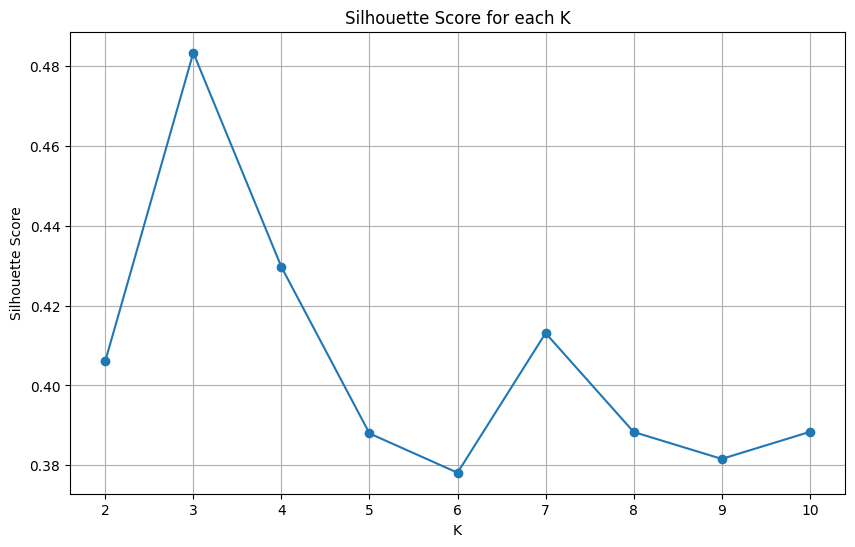

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

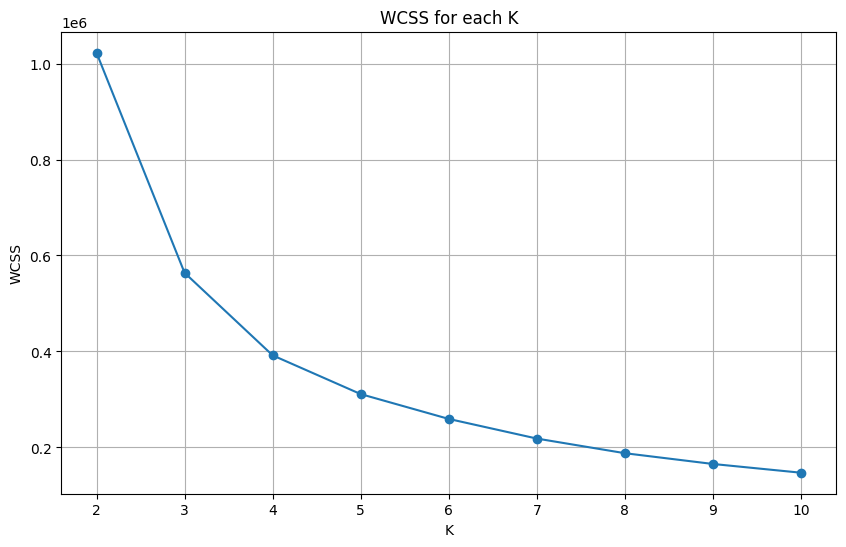

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression's accuracy: 1.0
K-Nearest Neighbors's accuracy: 1.0
Support Vector Machine's accuracy: 0.9856957087126138
Decision Tree's accuracy: 1.0
best_model: Logistic Regression


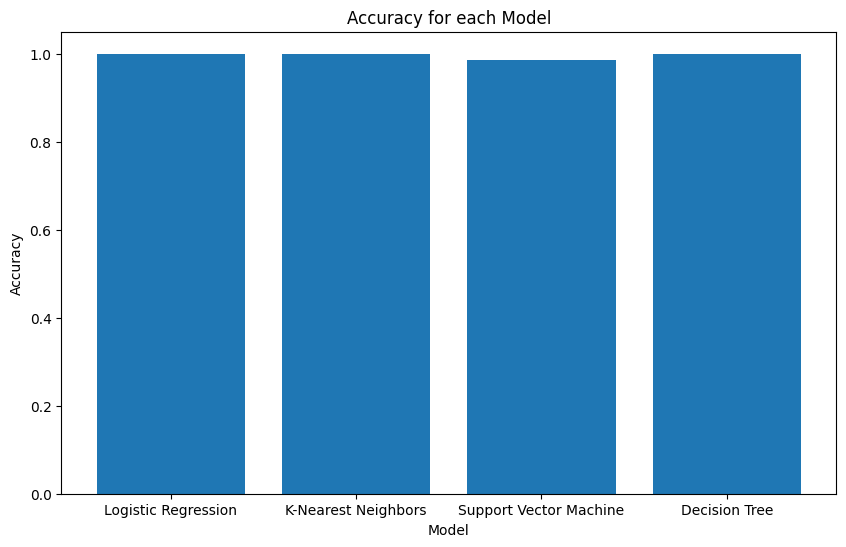

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# for second subtask
# difine sum of attempts for every activty, sum of max score for every activty
add_column_attempts_sum = "attempts_sum"
add_column_maxscore_sum = "maxscore_sum"
add_column_cluster_label = "cluster_label"

merged_df[add_column_attempts_sum] = merged_df[['Week 1 quiz', 'Week 2 quiz', 'Week 3 quiz',
            'Week 4 quiz', 'Week 5 quiz', 'Week 6 quiz', 'Week 7 quiz', 'Week 8 quiz', 'Week 9 quiz',
            'Week 10 quiz', 'Week 11 quiz', 'Week 12 quiz', 'Week 13 quiz', 'Week 14 quiz',
            'Week 15 quiz', 'Week 16 quiz', 'Week 1 homework', 'Week 2 homework',
            'Week 3 homework', 'Week 4 homework', 'Week 5 homework',
            'Week 7 homework', 'Week 8 homework', 'Week 9 homework', 'Week 10 homework', 'Week 11 homework',
            'Week 13 homework', 'Week 14 homework', 'Week 15 homework']].sum(axis=1)

merged_df[add_column_maxscore_sum] = merged_df[['Week 1 homework_maxscore',
            'Week 1 quiz_maxscore', 'Week 10 homework_maxscore', 'Week 10 quiz_maxscore', 'Week 11 homework_maxscore',
            'Week 11 quiz_maxscore', 'Week 12 quiz_maxscore', 'Week 13 homework_maxscore', 'Week 13 quiz_maxscore',
            'Week 14 homework_maxscore', 'Week 14 quiz_maxscore', 'Week 15 homework_maxscore', 'Week 15 quiz_maxscore',
            'Week 16 quiz_maxscore', 'Week 2 homework_maxscore', 'Week 2 quiz_maxscore', 'Week 3 homework_maxscore',
            'Week 3 quiz_maxscore', 'Week 4 homework_maxscore', 'Week 4 quiz_maxscore', 'Week 5 homework_maxscore',
            'Week 5 quiz_maxscore', 'Week 6 quiz_maxscore', 'Week 7 homework_maxscore', 'Week 7 quiz_maxscore',
            'Week 8 homework_maxscore', 'Week 8 quiz_maxscore', 'Week 9 homework_maxscore', 'Week 9 quiz_maxscore']].sum(axis=1)

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import joblib

# choose features: sum of attempts, sum of max score for every activity, course final score
f = merged_df[[add_column_attempts_sum, add_column_maxscore_sum, columns_name_score]].values
h = merged_df[columns_name_student].values

# unsupervised cluster analysis
best_k = -1
best_silhouette_score = -1

k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(f)
    silhouette_avg = silhouette_score(f, labels)
    silhouette_scores.append(silhouette_avg)
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_k = k

    print(f"K: {k}")
    print(f"silhouette_avg: {silhouette_avg}")

print(f"best_k: {best_k}")
# Plotting contour coefficients versus K-values
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for each K')
plt.xticks(k_values)
plt.grid(True)
plt.show()

wcss_new = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(f)
    wcss_new.append(kmeans.inertia_)

# Plotting WCSS versus K-values
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss_new, marker='o')
plt.xlabel('K')
plt.ylabel('WCSS')
plt.title('WCSS for each K')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Clustering using optimal K-values and save cluster labels
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(f)

merged_df[add_column_cluster_label] = labels

# Supervised learning for classification
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier()
}

best_model = None
best_accuracy = -1

accuracies = []
model_names = []

for model_name, model in models.items():
    # Separate the features and labels for training
    X_train = f
    y_train = merged_df[add_column_cluster_label]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on training data
    predicted_labels = model.predict(X_train)

    if model_name == 'Logistic Regression':
        joblib.dump(model, 'classification_model.joblib')

    accuracy = accuracy_score(y_train, predicted_labels)

    model_names.append(model_name)
    accuracies.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_name

    # Adding classification results to raw data
    merged_df[model_name] = predicted_labels

    # Calculation of silhouette coefficients
    silhouette_avg = silhouette_score(X_train, predicted_labels)

    print(f"{model_name}'s accuracy: {accuracy}")
    # print(f"{model_name}'s silhouette coefficient: {silhouette_avg}")

print(f"best_model: {best_model}")
# Chart model accuracy
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for each Model')
# plt.ylim([0, 1])
plt.show()


0# download the final
merged_df.to_csv('merged_df_classified_data.csv', index=False)
files.download('/content/classification_model.joblib')

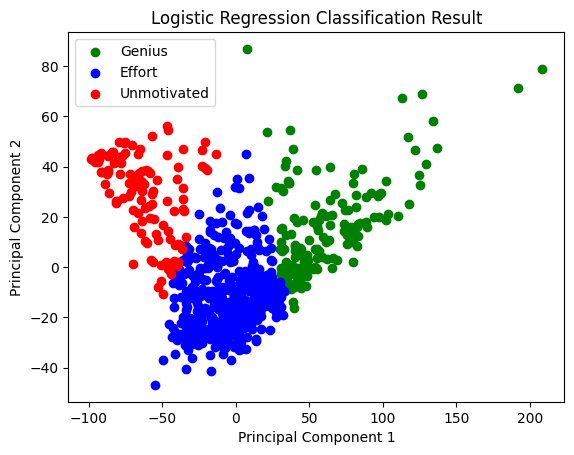

In [ ]:
from sklearn.decomposition import PCA

predicted_labels = merged_df["Logistic Regression"]
features = merged_df[[add_column_attempts_sum, add_column_maxscore_sum, columns_name_score]]

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.scatter(reduced_features[predicted_labels == 0, 0], reduced_features[predicted_labels == 0, 1], c='green', label='Genius')
plt.scatter(reduced_features[predicted_labels == 1, 0], reduced_features[predicted_labels == 1, 1], c='blue', label='Effort')
plt.scatter(reduced_features[predicted_labels == 2, 0], reduced_features[predicted_labels == 2, 1], c='red', label='Unmotivated')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Logistic Regression Classification Result')
plt.legend()

plt.show()

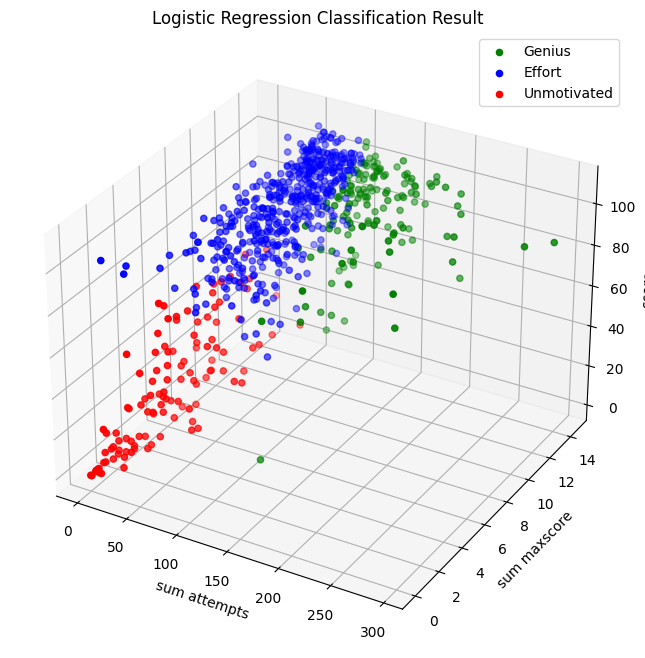

In [ ]:
import matplotlib.pyplot as plt

predicted_labels = merged_df["Logistic Regression"]
feature1 = merged_df[add_column_attempts_sum]
feature2 = merged_df[add_column_maxscore_sum]
feature3 = merged_df[columns_name_score]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(feature1[predicted_labels == 0], feature2[predicted_labels == 0], feature3[predicted_labels == 0], c='green', label='Genius')
ax.scatter(feature1[predicted_labels == 1], feature2[predicted_labels == 1], feature3[predicted_labels == 1], c='blue', label='Effort')
ax.scatter(feature1[predicted_labels == 2], feature2[predicted_labels == 2], feature3[predicted_labels == 2], c='red', label='Unmotivated')

ax.set_xlabel('sum attempts')
ax.set_ylabel('sum maxscore')
ax.set_zlabel('score')
ax.set_title('Logistic Regression Classification Result')
ax.legend()

plt.show()

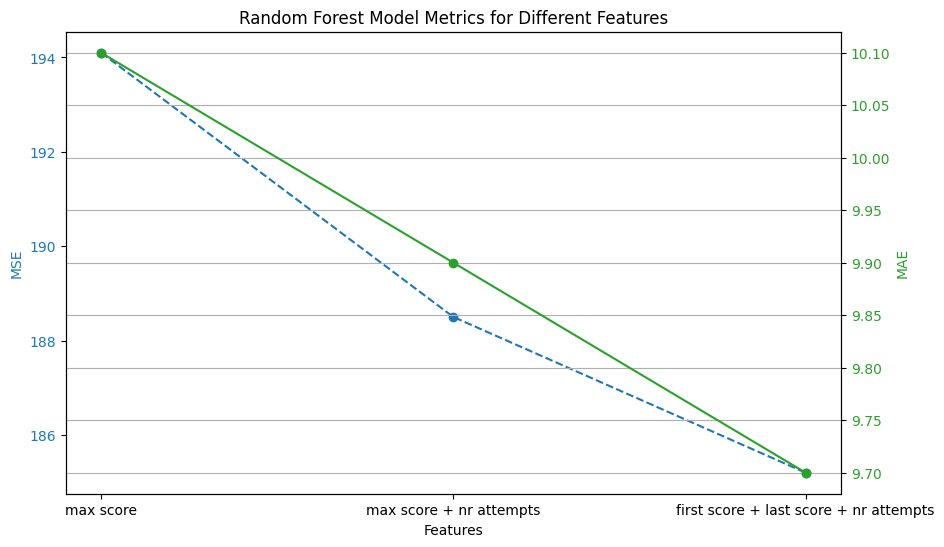

In [ ]:
import matplotlib.pyplot as plt

# Data
features = ["max score", "max score + nr attempts", "first score + last score + nr attempts"]
mse_values = [194.1, 188.5, 185.2]
mae_values = [10.1, 9.9, 9.7]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Features')
ax1.set_ylabel('MSE', color=color)
ax1.plot(features, mse_values, marker='o', linestyle='--', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('MAE', color=color)
ax2.plot(features, mae_values, marker='o', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Adding title
plt.title('Random Forest Model Metrics for Different Features')

# Display the plot
plt.grid(True)
plt.show()
